# Graph classification

A fundamental task in drug discovery is determining properties of molecules (on the order of millions) in search for promising molecules as drug candidates. 
However, running laboratory experiments to determine molecular properties are expensive. Instead, many drug companies utilize virtual screening methods in which computational methods are used to quickly search large libraries of molecules for one with the desirable properties -- size, toxicity, and absorption to name a few.
Success in virtual screening is determined by the accuracy and speed of the computational method. For instance, molecular dynamics simulates the physical movement of each atom and particle, thus providing the most accurate calculations of molecular properties, but requires an intractable number of numerical calculations that makes it infeasible to use in practice.
Instead, methods have been built around succint 2D representations of molecules, further compressed in 1D [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings (Simplified molecular-input line-entry system), that summarize the structural relationships between different atoms through the chemical bonds connecting them.

![title](Images/molecule_repr.png)

Using SMILES, practioners have built statistical models to estimate correlations between SMILES and different molecular 
properties. These traditional methods have relied on building hand-crafted features derived from SMILES and optimizing simplistic statistical models to predict molecular properties from fingerprints. In machine learning, we prefer to avoid hardcoding features and instead algorithmically determine the optimal features -- known as "learning". Observe that a SMILES is simply a graph where atoms are nodes and bonds are edges. We can utilize graph neural networks, introduced in [chapter 6](#link?), as a method for learning a transformation from a fingerprint to a set of graph embeddings that can maximize the accuracy of predicting molecular properties. 

Our problem is one instance of graph classification: provided a graph, we wish to estimate some property of it. Our task will be to build a graph neural network and train it for classifying whether a molecule is toxic. We will make use of the Pytorch Geometric library to build our neural network and train it. The goal is to introduce basic techniques in geometric deep learning through graph neural networks which have undoubtedly become indispensible tools in many applications beyond just drug discovery.


## Data processing

We will be using one of the datasets packaged in [MoleculeNet](https://moleculenet.org/). Pytorch geometric (PYG) provides a convenient module to access it. We first import the module `MoleculeNet` then extract the `ClinTox` dataset. The dataset has a total of 1478 molecules labeled with their presence or absence of toxicity -- determined from clinical trials done by the Food & Drug association (FDA). Since this is a binary classification task, we observe there are two classes.

In [1]:
from torch_geometric.datasets import MoleculeNet
dataset = MoleculeNet(root='data/clintox', name='ClinTox')
print(f'Dataset: {dataset}\nNumber of molecules/graphs: {len(dataset)}\nNumber of classes: {dataset.num_classes}')

/Users/jasonyim/miniforge3/envs/exp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: ClinTox(1478)
Number of molecules/graphs: 1478
Number of classes: 2


Let's look at a few molecules to understand their graph structure. Each molecule has a known 3D structure and an associated SMILES string.

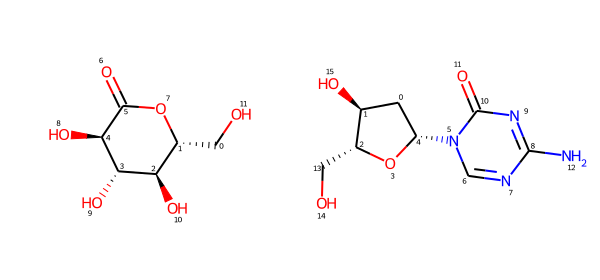

In [174]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mols = dataset[26], dataset[83]
smiles = [Chem.MolFromSmiles(m.smiles) for m in mols]
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addAtomIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Additionally, each atom has been labelled with a numerical index and corresponds to a node in our graph. A quick inspection shows the molecules have 12 and 14 atoms respectively. Each nodes has been preprocessed with cheminformatics software, [RDkit](https://www.rdkit.org/), to obtain a initial set of node features including atom-type, valences, formal charges, and hybridization. The details of each starting feature are not important for this tutorial, but are crucial in real-world applications to maximize performance.

In [175]:
for i,m in enumerate(mols):
    print(f'Molecule {i+1}: Number of atoms={m.x.shape[0]}, Features per atom={m.x.shape[1]}')

Molecule 1: Number of atoms=12, Features per atom=9
Molecule 2: Number of atoms=16, Features per atom=9


Let's now inspect the connectivity of each molecule. We'll render each molecule again but this time with the bond indices. 

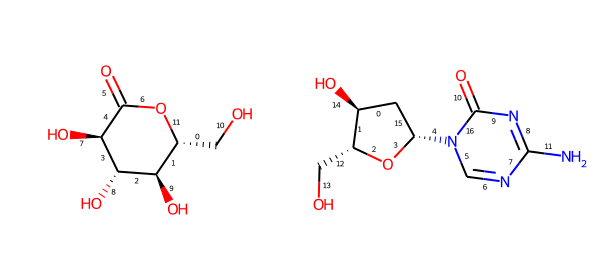

In [176]:
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addBondIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Bonds in the molecule correspond to edges in the graph. To verify this, let's inspect the adjacency matrix of each molecule's graph structure. PYG stores edges as adjacency lists to handle very large and sparse graphs. The following code converts the adjacency list into an adjacency matrix. We see the edge connectivity corresponds to the bond connectivity in the above images. For instance, atom 1 in the first molecule is bonded with atoms 0, 2, and 7 which agrees with the adjacency matrix.

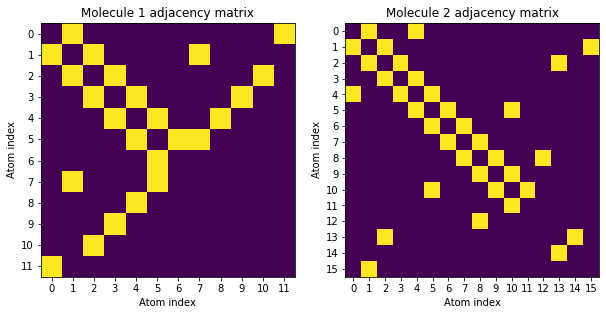

In [191]:
import numpy as np

fig, axes = plt.subplots(1, len(mols), figsize=(10, 5))
_process = lambda x: [e[0] for e in np.split(x, 2)]
for m_i, m in enumerate(mols):
    num_atoms = m.x.shape[0]
    connectivity_matrix = np.zeros([num_atoms, num_atoms])
    adj_list = m.edge_index.numpy()
    for e_i, (i,j) in enumerate(zip(*_process(adj_list))):
        connectivity_matrix[i, j] = 1
    axes[m_i].imshow(connectivity_matrix)
    axes[m_i].set_title(f'Molecule {m_i+1} adjacency matrix')
    axes[m_i].set_yticks(list(reversed(range(num_atoms))))
    axes[m_i].set_xticks(list(range(num_atoms)))
    axes[m_i].set_xlabel('Atom index')
    axes[m_i].set_ylabel('Atom index')

We chose these two molecules because the first is nono-toxic while the second is toxic. This can be observed from the associated labels. However, this is impossible to discern on first glance of the molecules without any expertise. We will now use a graph neural network to learn a function for classifying molecules as toxic.

In [198]:
for m_i, m in enumerate(mols):
    if m.y.long().numpy()[0, 1] == 1:
        print(f'Molecule {m_i+1} is toxic!')
    else:
        print(f'Molecule {m_i+1} is non-toxic.')

Molecule 1 is non-toxic.
Molecule 2 is toxic!


## Graph Neural Networks

We now understand the underlying structure of our molecular data is a graph - nodes represent atoms and edges represent chemical bonds.
Each molecule in our data is assigned a toxicity label obtained through experimental means, but the relationship between a molecular graph and toxicity is unknown.
We can approximate this relationship with a statistical model. Chapter 5 introduced several statistical models that assumed knowledge into the true underlying structure of the network, but this rarely happens in practice, especially for high-dimensional networks. Even when the structure is known, it is unclear how to construct a statistical model that can be feasibly optimized or learned. A practical solution has been to use graph neural networks (GNNs) which have two desirable properties that solve our aforementioned issues.

1. GNNs provide a framework for constructing universal function approximators on graphs. Informally, the right GNN model is _capable_ of closely approximating any function over arbitrary network structure. This is appealing as it says we do not have to invest time in creatively designing a statistical model. Instead, our time can now be spent systematicaly optimizing a GNN to learn the optimal network representation under the guarantee our statistical model is capable of recovering the correct model. We caveat the universal approximator property relies on technical assumptions and regularities but these discussions are outside the scope of this book.
2. GNNs are easy and efficient to optimize. A plethora of software libraries have been built to allow for neural network training and optimization. The success of neural networks is closely tied with the advent of special computer hardware, Graphical Processing Units (GPUs), that greatly accelerate and scale numerical calculations. GNNs are widely used in practice because they can scale to very large and high-dimensional datasets due to the tight coupling of engineering and mathematical theory.

Let us formally write down a GNN. Our formalism follows the message passing framework introduced in [Gilmer et al](http://proceedings.mlr.press/v70/gilmer17a/gilmer17a.pdf). The graph $G = (V, E)$ is parameterized by a set of nodes $V = \{v_i\}_{i=1}^{N_v}$ where $N_v = |V|$ and node attributes $v_i \in \mathbb{R}^{D_v}$. Edges in the graph are specified as $E = \{e_{ij}\}$ where $N_e = |E|$ and edge attributes $e_{ij} \in \mathbb{R}^{D_e}$ exists if there is a connection between nodes $i$ and $j$. GNNs works in two phases: 

1. **Message passing phase**. In this phase, the GNN sequentially updates node embeddings across $T$ timesteps. Each node embedding, $h_i^{(t)} \in \mathbb{R}^h$, and referred to as the _hidden state_ for node $i$ and timestep $t$. Each node embedding is initialized with node attributes $h_i^{(0)} = v_i$. For a given time-step, $t \in [T]$, we calculate _messages_ between every connected pair of nodes: $M_t(h_i^{(t-1)}, h_j^{(t-1)}, e_{ij})$ if $j \in N(i)$ where $N(i) = \{j : e_{ij} \in E\}$ are the neighboring nodes of node $i$. Many choices exist for parameterizing $M_t$ but it must be differentiable to make use of gradient-based optimization. A popular implementation for $M_t$ is the graph convolution network (GCN) layer from [Kipf et al](https://arxiv.org/abs/1609.02907) followed by a non-linear activation function, ReLU. This is what we will use in our implementation. We now perform the message passing step where each neighboring node will send their "messages" to a central node and then aggregate each message to construct a new hidden state. $$m_v^{(t)} = \sum_{j \in N(i)} M_{t-1}(h_i^{(t-1)}, h_j^{(t-1)}, e_{ij})$$ $$h_i^{(t)} = U_{t-1}(h_i^{(t-1)}, m_v^{(t)})$$
$U_{t-1}$ is the hidden-state update function. It also must be differentiable. Many papers are devoted to picking $U_{t-1}$, but for our purposes we will use the identity function to simplify our network.
2. **Readout phase**. After $T$ steps, the hidden states are computed as $\{h_i^{(T)}\}_{i=1}^{N_v}$, representing our final node embeddings. The read-out function, $R(\cdot)$, is a graph-level aggregation function combining all node embeddings into a single vector $r \in \mathbb{R}^{D_r}$. $$r = R(\{h_i^{(T)}\}_{i=1}^{N_v})$$ We choose to do a final embedding of this single vector with a fully-connected perceptron (Lin) before outputing it as the graph-classification prediction.$$\hat{y} = \text{Lin}(r)$$

With the model specified, we need an algorithm to learn the optimal parameters. The canonical loss for classification is cross-entropy (CE) which for binary classification simplifes to $$\text{CE}(y, \hat{y}) = -y(\log{\hat{y}} + (1-y)\log{(1 - \hat{y})})$$
for prediction $\hat{y} \in \mathbb{R}$ and label $y \in \{0, 1\}$. The full training objective can be written as $$\mathbb{E}_{(G, y) \sim p}\left[\text{CE}(y, \text{GNN}(G)) \right] = \sum_{(G, y)}\text{CE}(y, \text{GNN}(G)) \approx \sum_{i=1}^N\text{CE}(y, \text{GNN}(G))$$
We would wish to optimize over all possible graphs and labels that can be sampled $(G, y) \sim p$ where $p$ is the true distribution capturing the relationship between graphs and labels. But one never has access to the true distribution and needs to approximate using the given training data of size $N$. Often $N$ is very large and optimizing over every example at once is not possible. A successful, practical technique is to train stochastically: sample the maximum number of examples that can fit on the GPU, optimize it, then repeat by resampling until convergence of the loss or a validation metric.

Let us summarize what we've done so far. We specified our statistical model as a GNN that works by sequentially updating node embeddings to learn a function optimized according to a training objective. We hope minimizing this training objective will lead to a model that allows for accurate graph clasification. But this must be verified with a validation and test set. We brushed over many details regarding the rich topic of **deep learning**, of which 

## Model training

In [12]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:-150]
test_dataset = dataset[-150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1328
Number of test graphs: 150


In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    break

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1627, 9], edge_index=[2, 3458], edge_attr=[3458, 3], y=[64, 2], smiles=[64], batch=[1627], ptr=[65])


In [15]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes, bias=False)

    def forward(self, x, edge_index, batch):

        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
device = 'mps'
model = GCN(hidden_channels=64).to(device)
print(model)

GCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=False)
)


In [ ]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        
        out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y[:, 0].long())  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
        model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x.float(), data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y[:, 0]).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')